In [ ]:
"""Load the necessary python modules."""
 
import datetime
import getpass
import io
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from scipy import stats
import seaborn as sns
from typing import List, Text
import math
import itertools
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from colabtools import adhoc_import
from colabtools import drive
from colabtools import googlelog
from colabtools import interactive_forms
from colabtools import interactive_table
from colabtools import sheets
from google.colab import widgets
from google3.pyglib import gfile
%load_ext colabtools.interactive_table
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pylab
from pandas.plotting import register_matplotlib_converters
from six.moves import reload_module
from statsmodels.stats.stattools import medcouple
from datetime import datetime, timedelta

with adhoc_import.Google3():
  from colorama import Fore
  from colorama import Style

with adhoc_import.Google3():
    from google3.ads.amt.experiments.lc_experiments import utils
    from google3.ads.amt.experiments.lc_experiments import data_preparation_tools

register_matplotlib_converters()
InteractiveShell.ast_node_interactivity = "all"

def read_table_from_trix(trix_uri):
  ''' Read data from a trix_uri.
  Args:
    trix_uri: The trix uri to read data from.

  Returns: 
    A pandas data frame with data from the trix_uri.
  '''

  s_id = sheets.get_spreadsheet_id(trix_uri)
  w_id = sheets.get_worksheet_id(trix_uri)
  df = sheets.get_cells(s_id, w_id, has_col_header=True)
  return df

def plot_ts(df, scale: bool = False, start_date: pd.Timestamp = None,
            end_date: pd.Timestamp = None,subset: List[Text]=None,
            legend_bool: bool = True):
    """plot the timeseries data at the geo level.

    Args:
      df: the data frame containing the geo-level time series data.
      scale: boolean to be passed to change the y_scale to log.
      start_date: first day to include in the plot.
      end_date: last day to include in the plot.
      subset: set of stores to include in the plot.
      legend_bool: boolean to plot the legend
    """

    start_date = min(df["date"]) if start_date is None else start_date
    end_date = max(df["date"]) if end_date is None else end_date
    subset = (
        df["geo"].drop_duplicates() if subset is None else subset)

    valid_dates = (df["date"] >= start_date) & (df["date"] <= end_date)
    valid_geos = df["geo"].isin(subset)
    data_to_plot = df.loc[valid_dates & valid_geos]

    ax = data_to_plot.pivot_table(
        index="date", columns="geo", values="response", aggfunc="sum").plot(
            figsize=(20, 10), legend=legend_bool)
    ax.set_ylabel("Response")
    ax.set_xlabel("Date")
    if scale:
      ax.set_yscale("log")


'Load the necessary python modules.'

The colabtools.interactive_table extension is already loaded. To reload it, use:
  %reload_ext colabtools.interactive_table


In [ ]:
import numpy as np
import pandas as pd
              
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)



In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [ ]:
housing_train_data = "https://docs.google.com/spreadsheets/d/1Me1pChpe4jidG0-1iLlF4Tq2amKA52hemPC2KdCp5-0/edit#gid=1894926773"
housing_train_data = read_table_from_trix(housing_train_data)
housing_train_data.head(5)

Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape  \
2  1         60       RL          65    8450   Pave    NA      Reg   
3  2         20       RL          80    9600   Pave    NA      Reg   
4  3         60       RL          68   11250   Pave    NA      IR1   
5  4         70       RL          60    9550   Pave    NA      IR1   
6  5         60       RL          84   14260   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
4         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
5         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
6         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
2       Norm     1Fam     2Story           7           5      2003   
3       Norm     1Fam     1Story           6           8      1976   
4       Norm     1Fam     2Story           7           5      2001   
5       Norm     1Fam     2Story           7           5      1915   
6       Norm     1Fam     2Story           8           5      2000   

  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2         2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3         1976     Gable  CompShg     MetalSd     MetalSd       None   
4         2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5         1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
6         2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
2        196        Gd        TA      PConc       Gd       TA           No   
3          0        TA        TA     CBlock       Gd       TA           Gd   
4        162        Gd        TA      PConc       Gd       TA           Mn   
5          0        TA        TA     BrkTil       TA       Gd           No   
6        350        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF  \
2          GLQ        706          Unf          0       150         856   
3          ALQ        978          Unf          0       284        1262   
4          GLQ        486          Unf          0       434         920   
5          ALQ        216          Unf          0       540         756   
6          GLQ        655          Unf          0       490        1145   

  Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF  \
2    GasA        Ex          Y      SBrkr      856      854            0   
3    GasA        Ex          Y      SBrkr     1262        0            0   
4    GasA        Ex          Y      SBrkr      920      866            0   
5    GasA        Gd          Y      SBrkr      961      756            0   
6    GasA        Ex          Y      SBrkr     1145     1053            0   

  GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr  \
2      1710            1            0        2        1            3   
3      1262            0            1        2        0            3   
4      1786            1            0        2        1            3   
5      1717            1            0        1        0            3   
6      2198            1            0        2        1            4   

  KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
2            1          Gd            8        Typ          0          NA   
3            1          TA            6        Typ          1          TA   
4            1          Gd            6        Typ          1          TA   
5            1          Gd            7        Typ          1          Gd   
6            1          Gd            9        Typ          1          TA   

  GarageType GarageYrBlt Ga

In [ ]:
housing_test_data = "https://docs.google.com/spreadsheets/d/1FyTw24lZfss8_XH2MvPVxx_XkismNY94rMoujfvyA1g/edit#gid=1895795487"
housing_test_data = read_table_from_trix(housing_test_data)
housing_test_data.head(5)

Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape  \
2  1461         20       RH          80   11622   Pave    NA      Reg   
3  1462         20       RL          81   14267   Pave    NA      IR1   
4  1463         60       RL          74   13830   Pave    NA      IR1   
5  1464         60       RL          78    9978   Pave    NA      IR1   
6  1465        120       RL          43    5005   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
3         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
4         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
5         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
6         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
2       Norm     1Fam     1Story           5           6      1961   
3       Norm     1Fam     1Story           6           6      1958   
4       Norm     1Fam     2Story           5           5      1997   
5       Norm     1Fam     2Story           6           6      1998   
6       Norm   TwnhsE     1Story           8           5      1992   

  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2         1961     Gable  CompShg     VinylSd     VinylSd       None   
3         1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
4         1998     Gable  CompShg     VinylSd     VinylSd       None   
5         1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
6         1992     Gable  CompShg     HdBoard     HdBoard       None   

  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
2          0        TA        TA     CBlock       TA       TA           No   
3        108        TA        TA     CBlock       TA       TA           No   
4          0        TA        TA      PConc       Gd       TA           No   
5         20        TA        TA      PConc       TA       TA           No   
6          0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF  \
2          Rec        468          LwQ        144       270         882   
3          ALQ        923          Unf          0       406        1329   
4          GLQ        791          Unf          0       137         928   
5          GLQ        602          Unf          0       324         926   
6          ALQ        263          Unf          0      1017        1280   

  Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF  \
2    GasA        TA          Y      SBrkr      896        0            0   
3    GasA        TA          Y      SBrkr     1329        0            0   
4    GasA        Gd          Y      SBrkr      928      701            0   
5    GasA        Ex          Y      SBrkr      926      678            0   
6    GasA        Ex          Y      SBrkr     1280        0            0   

  GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr  \
2       896            0            0        1        0            2   
3      1329            0            0        1        1            3   
4      1629            0            0        2        1            3   
5      1604            0            0        2        1            3   
6      1280            0            0        2        0            2   

  KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
2            1          TA            5        Typ          0          NA   
3            1          Gd            6        Typ          0          NA   
4            1          TA            6        Typ          1          TA   
5            1          Gd            7        Typ          1          Gd   
6            1          Gd            5        Typ          0          NA   

  GarageType

# **Data Exploration**

In [ ]:
print("Number of train samples are", housing_train_data.shape)
print("Number of test samples are", housing_test_data.shape)

Number of train samples are (1460, 81)
Number of test samples are (1459, 80)


In [ ]:
# Looking at the columns in the dataset
housing_train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
# looking at the num of rows and columns in the data
housing_train_data.shape

(1460, 81)

In [ ]:
# checking dtypes
housing_train_data.dtypes

Id               object
MSSubClass       object
MSZoning         object
LotFrontage      object
LotArea          object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
OverallQual      object
OverallCond      object
YearBuilt        object
YearRemodAdd     object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1       object
BsmtFinType2     object
BsmtFinSF2       object
BsmtUnfSF        object
TotalBsmtSF      object
Heating          object
HeatingQC        object
CentralAir      

In [ ]:
# describing the data
housing_train_data.describe()

Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape  \
count   1460       1460     1460        1460    1460   1460  1460     1460   
unique  1460         15        5         111    1073      2     3        4   
top      289         20       RL          NA    7200   Pave    NA      Reg   
freq       1        536     1151         259      25   1454  1369      925   

       LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
count         1460      1460      1460      1460         1460       1460   
unique           4         2         5         3           25          9   
top            Lvl    AllPub    Inside       Gtl        NAmes       Norm   
freq          1311      1459      1052      1382          225       1260   

       Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
count        1460     1460       1460        1460        1460      1460   
unique          8        5          8          10           9       112   
top          Norm     1Fam     1Story           5           5      2006   
freq         1445     1220        726         397         821        67   

       YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
count          1460      1460     1460        1460        1460       1460   
unique           61         6        8          15          16          5   
top            1950     Gable  CompShg     VinylSd     VinylSd       None   
freq            178      1141     1434         515         504        864   

       MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
count        1460      1460      1460       1460     1460     1460   
unique        328         4         5          6        5        5   
top             0        TA        TA      PConc       TA       TA   
freq          861       906      1282        647      649     1311   

       BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF  \
count          1460         1460       1460         1460       1460      1460   
unique            5            7        637            7        144       780   
top              No          Unf          0          Unf          0         0   
freq            953          430        467         1256       1293       118   

       TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF  \
count         1460    1460      1460       1460       1460     1460     1460   
unique         721       6         5          2          6      753      417   
top              0    GasA        Ex          Y      SBrkr      864        0   
freq            37    1428       741       1365       1334       25      829   

       LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath  \
count          1460      1460         1460         1460     1460     1460   
unique           24       861            4            3        4        3   
top               0       864            0            0        2        0   
freq           1434        22          856         1378      768      913   

       BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional  \
count          1460         1460        1460         1460       1460   
unique            8            4           4           12          7   
top               3            1          TA            6        Typ   
freq            804         1392         735          402       1360   

       Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars  \
count        1460        1460       1460        1460         1460       1460   
unique          4           6          7          98            4          5   
top             0          NA     Attchd          NA          Unf          2   
freq          690         690        870          81          605        824   

       GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF  \
count        1460       1460       1460       1460       1460        1460   
unique        44

In [ ]:
housing_train_data.head(2)

Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape  \
2  1         60       RL          65    8450   Pave    NA      Reg   
3  2         20       RL          80    9600   Pave    NA      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   

  Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
2       Norm     1Fam     2Story           7           5      2003   
3       Norm     1Fam     1Story           6           8      1976   

  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2         2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3         1976     Gable  CompShg     MetalSd     MetalSd       None   

  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
2        196        Gd        TA      PConc       Gd       TA           No   
3          0        TA        TA     CBlock       Gd       TA           Gd   

  BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF  \
2          GLQ        706          Unf          0       150         856   
3          ALQ        978          Unf          0       284        1262   

  Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF  \
2    GasA        Ex          Y      SBrkr      856      854            0   
3    GasA        Ex          Y      SBrkr     1262        0            0   

  GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr  \
2      1710            1            0        2        1            3   
3      1262            0            1        2        0            3   

  KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
2            1          Gd            8        Typ          0          NA   
3            1          TA            6        Typ          1          TA   

  GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual  \
2     Attchd        2003          RFn          2        548         TA   
3     Attchd        1976          RFn          2        460         TA   

  GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch  \
2         TA          Y          0          61             0         0   
3         TA          Y        298           0             0         0   

  ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
2           0        0     NA    NA          NA       0      2   2008   
3           0        0     NA    NA          NA       0      5   2007   

  SaleType SaleCondition SalePrice  
2       WD        Normal    208500  
3       WD        Normal    181500

In [ ]:
# descriving a particular column
housing_train_data['SalePrice'].describe()

count       1460
unique       663
top       140000
freq          20
Name: SalePrice, dtype: object

In [ ]:
cols = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
housing_train_data[cols] = housing_train_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)
housing_test_data[cols] = housing_test_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)

target_col = ['SalePrice']
housing_train_data[target_col] = housing_train_data[target_col].apply(pd.to_numeric, errors='coerce', axis=1)

In [ ]:
# converting the columns to integer to plot the data
# housing_train_data['SalePrice'] = housing_train_data['SalePrice'].astype(int)
# housing_train_data['TotalBsmtSF'] = housing_train_data['TotalBsmtSF'].astype(int)
# housing_train_data['GrLivArea'] = housing_train_data['GrLivArea'].astype(int)
# housing_train_data['OverallQual'] = housing_train_data['OverallQual'].astype(int)

In [ ]:
housing_train_data.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2  1       60.00       RL        65.00 8,450.00   Pave    NA      Reg   
3  2       20.00       RL        80.00 9,600.00   Pave    NA      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond YearBuilt  \
2       Norm     1Fam     2Story         7.00         5.00      2003   
3       Norm     1Fam     1Story         6.00         8.00      1976   

  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2         2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3         1976     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
2      196.00        Gd        TA      PConc       Gd       TA           No   
3        0.00        TA        TA     CBlock       Gd       TA           Gd   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
2          GLQ      706.00          Unf        0.00     150.00       856.00   
3          ALQ      978.00          Unf        0.00     284.00     1,262.00   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
2    GasA        Ex          Y      SBrkr    856.00    854.00          0.00   
3    GasA        Ex          Y      SBrkr  1,262.00      0.00          0.00   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
2   1,710.00          1.00          0.00      2.00      1.00          3.00   
3   1,262.00          0.00          1.00      2.00      0.00          3.00   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
2          1.00          Gd          8.00        Typ        0.00          NA   
3          1.00          TA          6.00        Typ        1.00          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
2     Attchd     2,003.00          RFn        2.00      548.00         TA   
3     Attchd     1,976.00          RFn        2.00      460.00         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
2         TA          Y        0.00        61.00           0.00       0.00   
3         TA          Y      298.00         0.00           0.00       0.00   

   ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold   YrSold  \
2         0.00      0.00     NA    NA          NA     0.00    2.00 2,008.00   
3         0.00      0.00     NA    NA          NA     0.00    5.00 2,007.00   

  SaleType SaleCondition  SalePrice  
2       WD        Normal     208500  
3       WD        Normal     181500

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


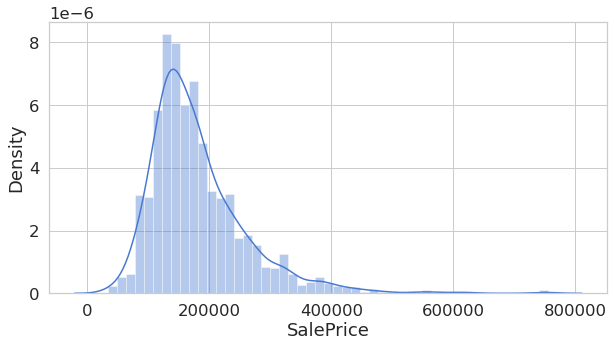

In [ ]:
sns.distplot(housing_train_data['SalePrice']);

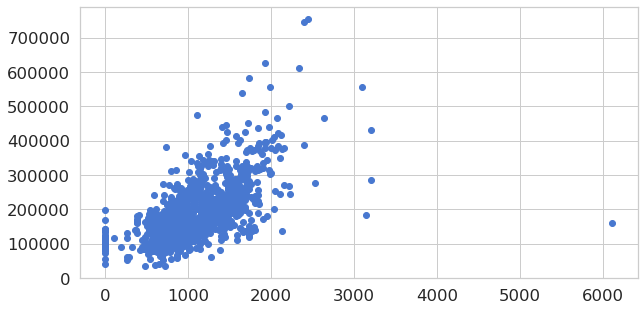

In [ ]:
plt.scatter(x = housing_train_data['TotalBsmtSF'], y = housing_train_data['SalePrice'])

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

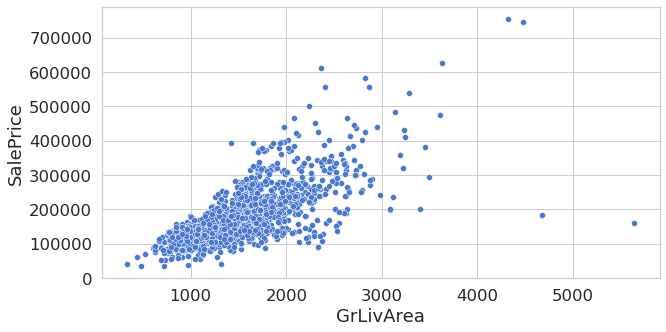

In [ ]:
sns.scatterplot(data=housing_train_data, x='GrLivArea', y='SalePrice')

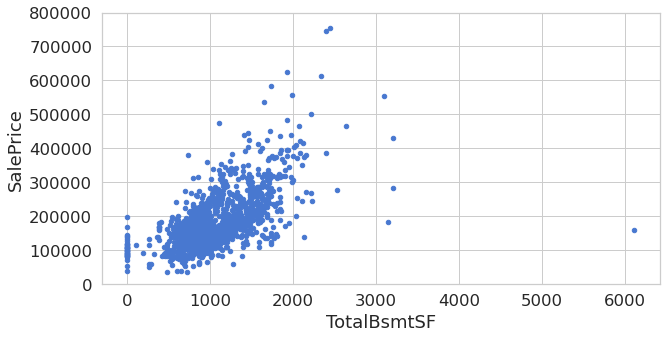

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([housing_train_data['SalePrice'], housing_train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

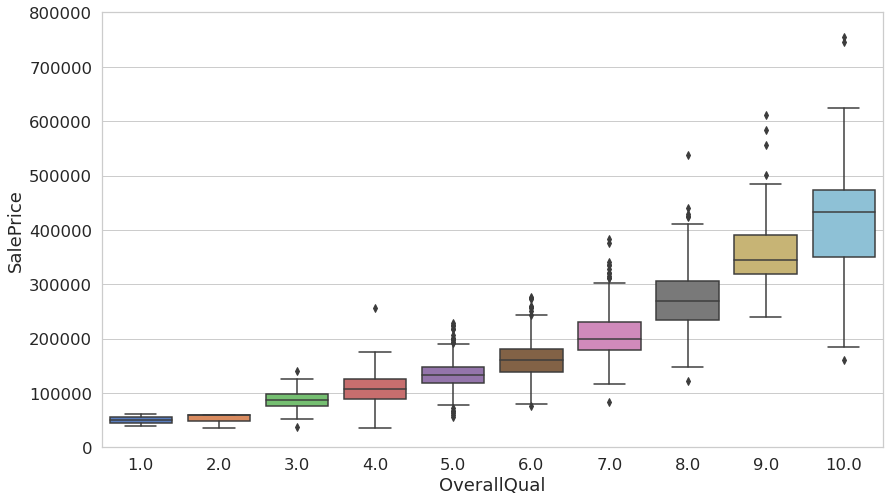

In [ ]:
var = 'OverallQual'
data = pd.concat([housing_train_data['SalePrice'], housing_train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


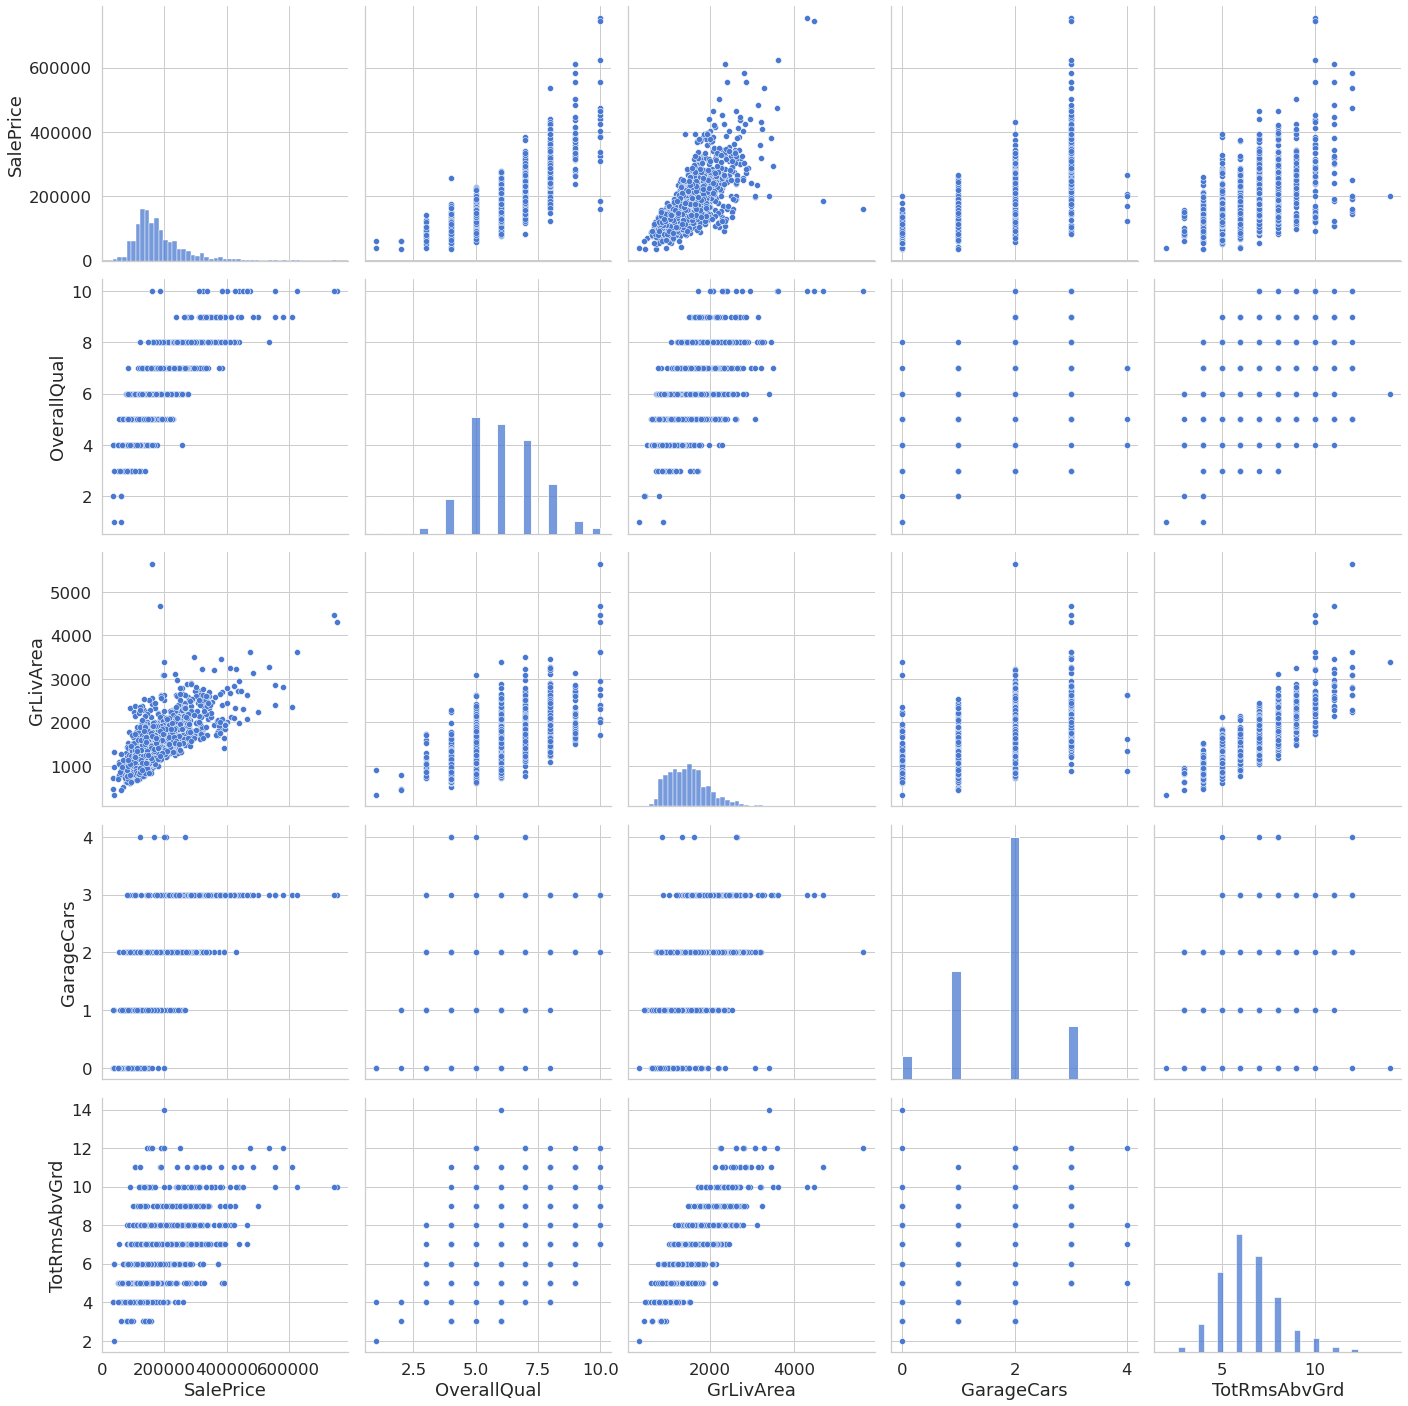

In [ ]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotRmsAbvGrd']
sns.pairplot(housing_train_data[cols], size = 4);

<Figure size 1500x200 with 0 Axes>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

Text(0.5, 1.0, 'SalePrice distribution')

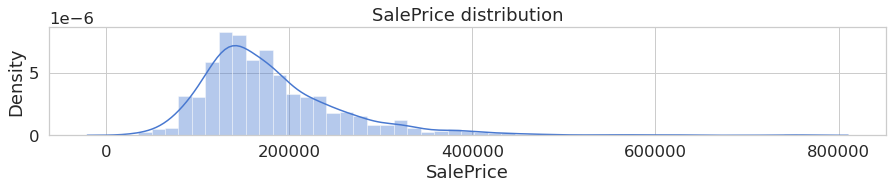

<Figure size 1500x200 with 0 Axes>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='OverallQual', ylabel='Density'>

Text(0.5, 1.0, 'OverallQual distribution')

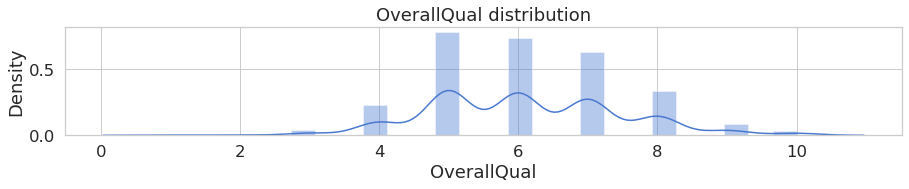

<Figure size 1500x200 with 0 Axes>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

Text(0.5, 1.0, 'GrLivArea distribution')

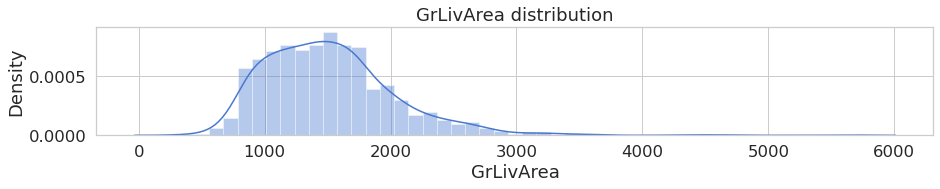

<Figure size 1500x200 with 0 Axes>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GarageCars', ylabel='Density'>

Text(0.5, 1.0, 'GarageCars distribution')

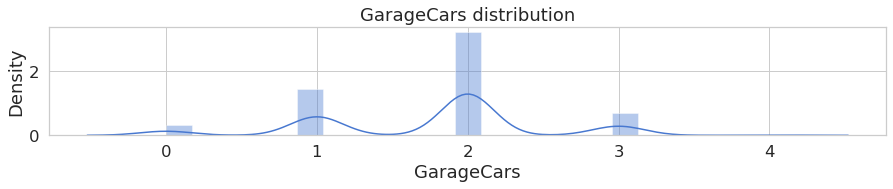

<Figure size 1500x200 with 0 Axes>

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='Density'>

Text(0.5, 1.0, 'TotRmsAbvGrd distribution')

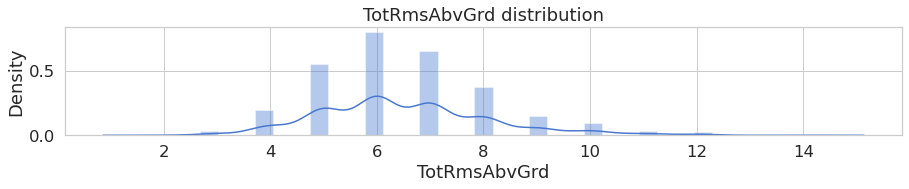

In [ ]:
for col in cols:
    plt.figure(figsize=(15, 2))
    sns.distplot(housing_train_data[col],kde=True)
    plt.title(col+" distribution")
    #i=i+1
    plt.show()

# Exploratory Data Analysis

# Correlation Analysis

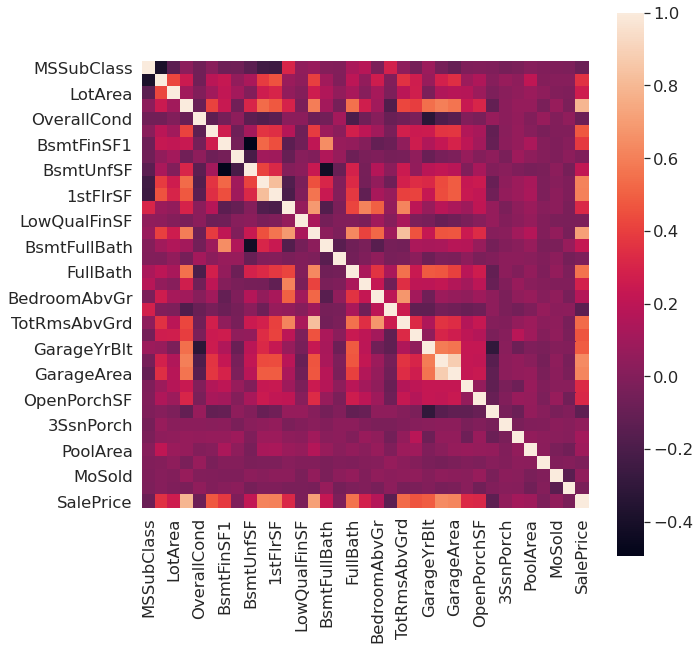

In [ ]:
corrmat = housing_train_data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, square=True);

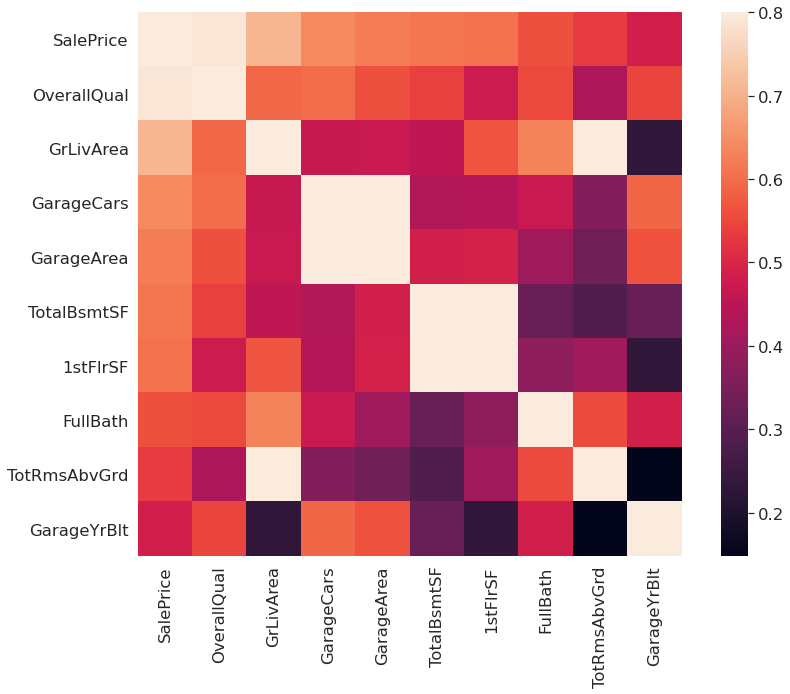

In [ ]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(housing_train_data[cols].corr(), vmax=.8, square=True);

# Feature Engineering

In [ ]:
# columns wit missing values
cols_with_missing = [col for col in housing_train_data.columns 
                                 if housing_train_data[col].isnull().any()]
miss_count = housing_train_data.isna().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(housing_train_data)).rename('Missing value')],axis = 1).loc[miss_count.ne(0)])
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value
LotFrontage,259,0.177397
MasVnrArea,8,0.005479
GarageYrBlt,81,0.055479


In [ ]:
# Substituting missing values for Year Built as 2022
housing_train_data['GarageYrBlt'] = housing_train_data['GarageYrBlt'].replace(np.nan, 2022)

In [ ]:
# Use simple imputer for other columns
from sklearn.impute import SimpleImputer
null_cols=['LotFrontage', 'MasVnrArea']
imp = SimpleImputer(missing_values=np.nan, strategy='median')

housing_train_data[null_cols]  = imp.fit_transform(housing_train_data[null_cols])
housing_test_data[null_cols]  = imp.transform(housing_test_data[null_cols])

In [ ]:
# rechecking columns wit missing values after imputation
cols_with_missing = [col for col in housing_train_data.columns 
                                 if housing_train_data[col].isnull().any()]
miss_count = housing_train_data.isna().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(housing_train_data)).rename('Missing value')],axis = 1).loc[miss_count.ne(0)])
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value


# Feature Engineering

In [ ]:
housing_train_data = housing_train_data.drop(columns = 'Id')
housing_test_data = housing_test_data.drop(columns = 'Id')

categorical_cols=[c for c in housing_train_data.columns if (1<housing_train_data[c].nunique()) & (housing_train_data[c].dtype != np.number)& (housing_train_data[c].dtype != int) & (housing_train_data[c].dtype != 'float64')]

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_aroramanisha.kernel.aroramanisha.4731624211147.14b334fb3717c109/mount/server/ml_notebook:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


In [ ]:
le = LabelEncoder()
for col in categorical_cols:
    housing_train_data[col] = le.fit_transform(housing_train_data[col])
    housing_test_data[col] = le.fit_transform(housing_test_data[col])

In [ ]:
housing_train_data.head(5)

MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  LotShape  \
2       60.00         3        65.00  8,450.00       1      1         3   
3       20.00         3        80.00  9,600.00       1      1         3   
4       60.00         3        68.00 11,250.00       1      1         0   
5       70.00         3        60.00  9,550.00       1      1         0   
6       60.00         3        84.00 14,260.00       1      1         0   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
2            3          0          4          0             5           2   
3            3          0          2          0            24           1   
4            3          0          4          0             5           2   
5            3          0          0          0             6           2   
6            3          0          2          0            15           2   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
2           2         0           5         7.00         5.00        104   
3           2         0           2         6.00         8.00         77   
4           2         0           5         7.00         5.00        102   
5           2         0           5         7.00         5.00         19   
6           2         0           5         8.00         5.00        101   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
2            53          1         1           12           13           1   
3            26          1         1            8            8           3   
4            52          1         1           12           13           1   
5            20          1         1           13           15           3   
6            50          1         1           12           13           1   

   MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
2      196.00          2          4           2         2         4   
3        0.00          3          4           1         2         4   
4      162.00          2          4           2         2         4   
5        0.00          3          4           0         4         1   
6      350.00          2          4           2         2         4   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
2             4             2      706.00             6        0.00   
3             1             0      978.00             6        0.00   
4             2             2      486.00             6        0.00   
5             4             0      216.00             6        0.00   
6             0             2      655.00             6        0.00   

   BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  Electrical  \
2     150.00       856.00        1          0           1           5   
3     284.00     1,262.00        1          0           1           5   
4     434.00       920.00        1          0           1           5   
5     540.00       756.00        1          2           1           5   
6     490.00     1,145.00        1          0           1           5   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
2    856.00    854.00          0.00   1,710.00          1.00          0.00   
3  1,262.00      0.00          0.00   1,262.00          0.00          1.00   
4    920.00    866.00          0.00   1,786.00          1.00          0.00   
5    961.00    756.00          0.00   1,717.00          1.00          0.00   
6  1,145.00  1,053.00          0.00   2,198.00          1.00          0.00   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
2      2.00      1.00          3.00          1.00            2          8.00   
3      2.00      0.00          3.00          1.00            3          6.00   
4      2.00      1.00          3.00          1.00            2          6.00   
5      1.00      0.00          3.00          1.00            2          7.00   
6

In [ ]:
y = housing_train_data['SalePrice']
X = housing_train_data.drop(columns = 'SalePrice')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_train_features = scaler.fit_transform(X)
housing_test_data = scaler.transform(housing_test_data)

In [1]:
# output of scalar transformation is numpy array so convert it into dataframe
scaled_features_df = pd.DataFrame(scaled_features, index = X.index, columns=X.columns)

NameError: ignored

# Model Building

In [ ]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing_train_features, y, test_size = 0.2, random_state = 50)

In [ ]:
# Fitting the regression model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Understanding regression scores on train and test data
print('Regression score on train data is: ', round(reg.score(X_train, y_train),2))
print('Regression score on test data is: ', round(reg.score(X_test, y_test),2))

Regression score on train data is:  0.85
Regression score on test data is:  0.82


In [ ]:
### End of code ###